In [17]:
!pip install git+https://github.com/sebastian-sz/efficientnet-v2-keras@main

  Cloning https://github.com/sebastian-sz/efficientnet-v2-keras (to revision main) to /tmp/pip-req-build-20azwtmx
  Running command git clone --filter=blob:none --quiet https://github.com/sebastian-sz/efficientnet-v2-keras /tmp/pip-req-build-20azwtmx
  Resolved https://github.com/sebastian-sz/efficientnet-v2-keras to commit ae40524cdfc67cef0c40e89f76394042ca6497b9
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-v2-keras: filename=efficientnet_v2_keras-1.0-py3-none-any.whl size=15400 sha256=297124a27f913f0994053573b822a856bed31aacf34297a68085eec2d53a8321
  Stored in directory: /tmp/pip-ephem-wheel-cache-qj2z3z97/wheels/9f/64/18/5e19e68f416c0dd72251d3f4700f7df9da70d3e8ccfa2bf844
Successfully built efficientnet-v2-keras


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet_v2 import EfficientNetV2M

%matplotlib inline

In [2]:
class_num = 3
batch_size=32
target_size=(200,200)

gen = ImageDataGenerator(rescale=1/255.)
train_gen = gen.flow_from_directory('./data/train/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = gen.flow_from_directory('./data/valid/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = gen.flow_from_directory('./data/test/', target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True)

Found 9180 images belonging to 3 classes.
Found 3060 images belonging to 3 classes.
Found 3060 images belonging to 3 classes.


In [3]:
transfer_base = EfficientNetV2M(weights='imagenet',
                          include_top=False,        # class 3개로 분류 학습시켜야 해서 레이어 분리시킨 후, Desnse(3) 추가..?
                          input_shape=(200, 200, 3))
transfer_base.summary()

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 100, 100, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 100, 100, 24) 96          stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 100, 100, 24) 0           stem_bn[0][0]                    
___________________________________________________________________________________

In [4]:
model = models.Sequential()
model.add(transfer_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(class_num, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-m (Functional (None, 7, 7, 1280)        53150388  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 53,479,095
Trainable params: 53,187,063
Non-trainable params: 292,032
_________________________________________________________________


In [6]:
#저장할 모델명(폴더명)
model_name = 'EffNetV2M'

#폴더생성
if 'save_models' not in os.listdir(): os.mkdir('save_models')
if model_name not in os.listdir('save_models'): os.mkdir('./save_models/{}'.format(model_name))
#모델 저장 path
path_checkpoint = "./save_models/{}/".format(model_name) 
#모델 저장 코드(weight만 저장)
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, save_weights_only=False, save_best_only=True, save_format='tf')

#fit
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_gen, validation_data=valid_gen, batch_size=batch_size, epochs=10, callbacks=[es_callback, modelckpt_callback])

Epoch 1/10
287/287 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9794
Epoch 00001: val_loss improved from inf to 0.04787, saving model to ./save_models/EffNetV2M/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./save_models/EffNetV2M/assets
287/287 [==============================] - 243s 847ms/step - loss: 0.0682 - accuracy: 0.9794 - val_loss: 0.0479 - val_accuracy: 0.9830
Epoch 2/10
287/287 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9981
Epoch 00002: val_loss did not improve from 0.04787
287/287 [==============================] - 143s 497ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0698 - val_accuracy: 0.9824
Epoch 3/10
287/287 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.997

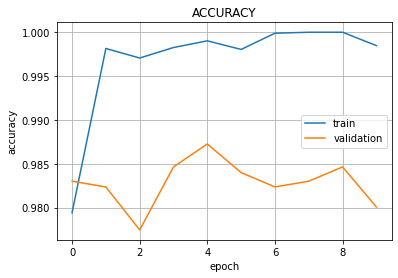

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['train','validation'], loc = 'best')

In [8]:
#저장된 최고 성능 모델 불러오기
model_loaded = tf.keras.models.load_model(path_checkpoint)

#test score 확인
score = model_loaded.evaluate(test_gen) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

96/96 [==============================] - 11s 120ms/step - loss: 0.0762 - accuracy: 0.9752
Test loss: 0.07621503621339798
Test accuracy: 0.9751634001731873
